### Import Libraries

In [1]:
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import math
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set Seed

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Variable Definition

In [3]:
input_dir = "../input"
dataset_dir = os.path.join(input_dir, 'dataset')
aut_72_dir = os.path.join(input_dir, 'autoregression-72/SubmissionModel')
ed_3690_dir = os.path.join(input_dir, 'encoder-decoder-3690/SubmissionModel')
ed_3390_dir = os.path.join(input_dir, 'encoder-decoder-108-3390/SubmissionModel')

column_names = ['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact', 'Meme creativity', 'Soap slipperiness', 'Hype root']

window_3690 = 3690
window_3390 = 3390
window_200 = 200
stride = 30
telescope_72 = 72
telescope = 108


### Exploring Data Analysis (EDA)

#### Load the dataset

In [4]:
dataset = pd.read_csv(os.path.join(dataset_dir, 'Training.csv'))
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


#### Train and Test split

(68528, 7) (6852, 7)


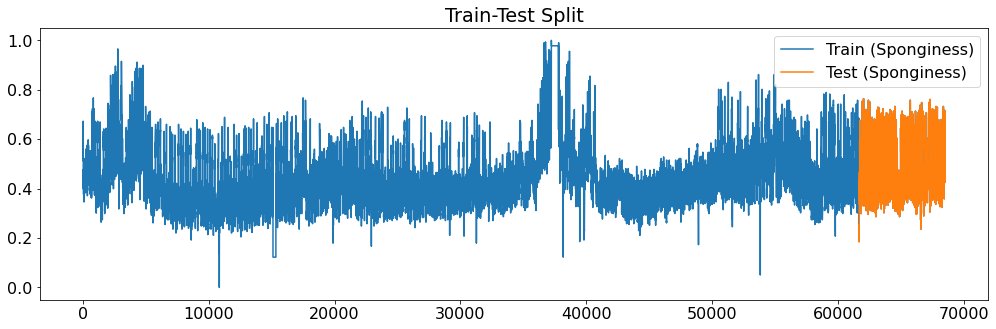

In [6]:
# The test set is 10% the training set
test_size = math.floor(len(dataset) * 0.1)
#X_train_raw = dataset.iloc[:-test_size]
X_train_raw = dataset.iloc[:]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Min Max normalization of both sets
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train (Sponginess)')
plt.plot(X_test_raw['Sponginess'], label='Test (Sponginess)')

plt.title('Train-Test Split')
plt.legend()
plt.show()

In [7]:
future_72 = dataset[-window_200:]
future_72 = (future_72 - X_min) / (X_max - X_min)
future_72 = np.expand_dims(future_72, axis=0)
future_72.shape

future_3690 = dataset[-window_3690:]
future_3690 = (future_3690 - X_min) / (X_max - X_min)
future_3690 = np.expand_dims(future_3690, axis=0)
future_3690.shape

future_3390 = dataset[-window_3390:]
future_3390 = (future_3390 - X_min) / (X_max - X_min)
future_3390 = np.expand_dims(future_3390, axis=0)
future_3390.shape

(1, 3390, 7)

In [8]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting

In [9]:
batch_size = 64
epochs = 200
reg_telescope = 864

In [10]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if idx == None:
        idx = np.random.randint(0, len(X))
    
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [11]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if idx == None:
        idx = np.random.randint(0, len(X))
    
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [12]:
#model.save("Encoder_Decoder")

aut_72 = tfk.models.load_model(aut_72_dir)
ed_3690 = tfk.models.load_model(ed_3690_dir)
ed_3390 = tfk.models.load_model(ed_3390_dir)

2022-01-21 17:11:03.649780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 17:11:03.774375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 17:11:03.775064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 17:11:03.776166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
out_72 = np.array([])
X_temp = future_72
for reg in range(0,reg_telescope,telescope_72):
    #Predict next telescope samples
    pred_temp = aut_72.predict(X_temp)
    if(len(out_72)==0):
        out_72 = pred_temp
    else:
        #Concatenate predicted samples to the dataset
        out_72 = np.concatenate((out_72,pred_temp),axis=1)
    #Slide the window for next prediction
    X_temp = np.concatenate((X_temp[:,telescope_72:,:],pred_temp), axis=1)


2022-01-21 17:11:32.312452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 17:11:34.139737: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [14]:
out_3690 = np.array([])
X_temp = future_3690
for reg in range(0,reg_telescope,telescope):
    #Predict next telescope samples
    pred_temp = ed_3690.predict(X_temp)
    if(len(out_3690)==0):
        out_3690 = pred_temp
    else:
        #Concatenate predicted samples to the dataset
        out_3690 = np.concatenate((out_3690,pred_temp),axis=1)
    #Slide the window for next prediction
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)


In [15]:
out_3390 = np.array([])
X_temp = future_3390
for reg in range(0,reg_telescope,telescope):
    #Predict next telescope samples
    pred_temp = ed_3390.predict(X_temp)
    if(len(out_3390)==0):
        out_3390 = pred_temp
    else:
        #Concatenate predicted samples to the dataset
        out_3390 = np.concatenate((out_3390,pred_temp),axis=1)
    #Slide the window for next prediction
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [16]:
out_72.shape, out_3690.shape, out_3390.shape

((1, 864, 7), (1, 864, 7), (1, 864, 7))

In [17]:
out = np.copy(out_3690)

for r in range(reg_telescope):
    out[0][r][0] = out_3390[0][r][0]
    out[0][r][5] = out_72[0][r][5]
        

In [18]:
X_test_reg, y_test_reg = build_sequences(X_test_raw, column_names, window_3690, stride, reg_telescope)

In [19]:
maes = []
for i in range(out.shape[1]):
    ft_maes = []
    for j in range(out.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-out[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [20]:
out.shape

(1, 864, 7)

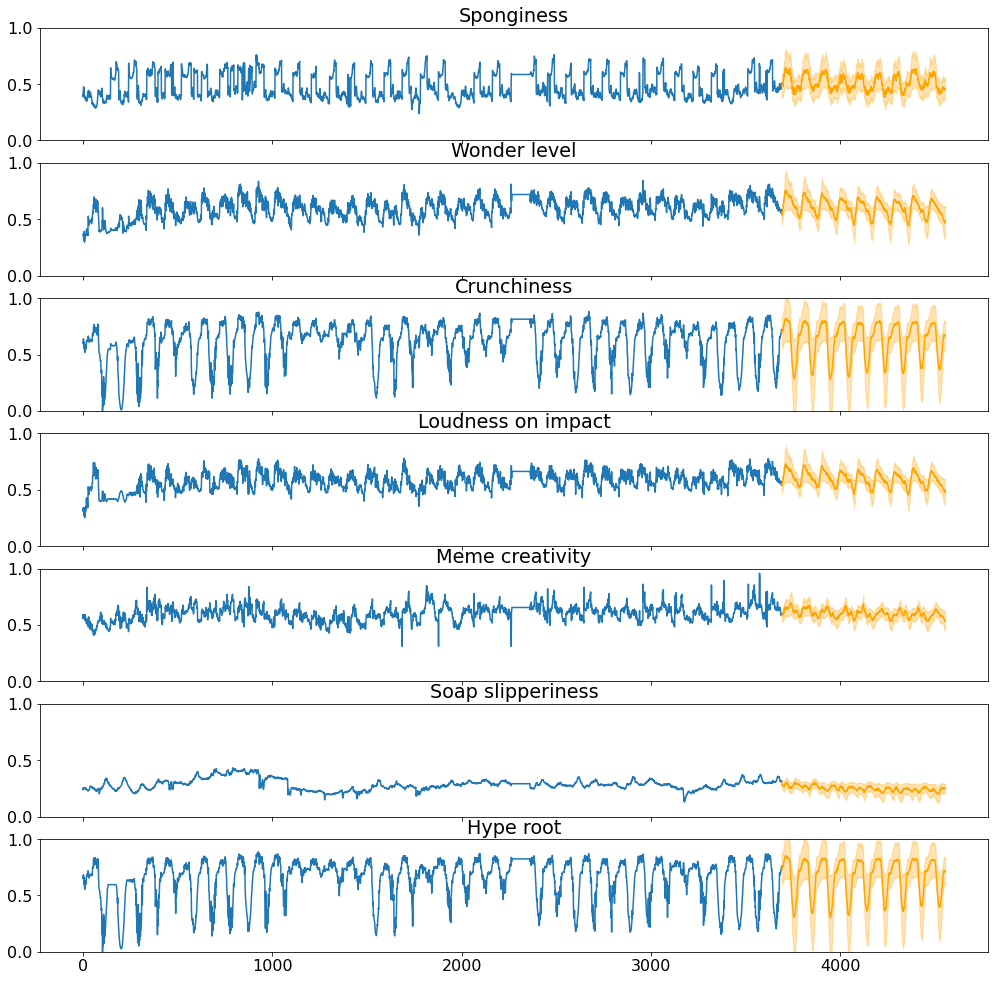

In [21]:
figs, axs = plt.subplots(len(column_names), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(column_names):
    axs[i].plot(np.arange(len(future_3690[0,:,i])), future_3690[0,:,i])
    axs[i].plot(np.arange(len(future_3690[0,:,i]), len(future_3690[0,:,i])+reg_telescope), out[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future_3690[0,:,i]), len(future_3690[0,:,i])+reg_telescope), 
        out[0,:,i]+maes[:,i], 
        out[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

#### Cross Validation